# Fine-tuning to follow instructions

## Introduction to instruction fine-tuning

205-215

Gneral process
1. Download dataset and format it
2. Batch the dataset
3. Create data loaders
4. Load a pretrained LLM
5. Instruction fine-tune the LLM
6. Inspect the loss
7. Extract responses
8. Evaluate (qualitative)
9. Score the response

## Preparing a dataset for supervised instruction fine-tuning

1,100 instruction–response pairs

In [1]:
import json
import os
import urllib


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [3]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


alpaca style

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request. "
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


Partition the dataset

In [7]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion : train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into training batches

- pythorch `dataloader` can automatically create training batches
- it uses default `collate` function to combine lists of samples into batches
- but batching process for instruction fine-tuning is a bit more involved and requires us to create our own custom collate function

Batching process in 5 steps:
1. Format data using prompt template: instruction-response template
2. Tokenize formatted data: encode to token IDs
3. Adjust to the same length w/ padding tokens: end-of-text tokens (50256)
4. Create target token IDs for training: input shifted by 1 + additional padding
5. Replace padding tokens w/ placeholders: use -100 to exclude them from training loss

implement an instruction dataset class

In [8]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))
            
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)
            

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


custom collate function
- pads the training examples in each batch to the same length
- only extend the sequence to match the longest on in the batch, not the whole dataset

In [10]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item) for item in batch)
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        # new_item += [pad_token_id]
        
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded)
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (inputs_1, inputs_2, inputs_3)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


Creating input-target pairs: we shift the token IDs by one position to the right, and add the padding token ID

In [12]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item) for item in batch)
    inputs_lst, target_lst = [], []
    for item in batch:
        new_item = item.copy()

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item) + 1)
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        target_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    target_tensor = torch.stack(target_lst).to(device)
    return inputs_tensor, target_tensor

In [13]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- Assign -100 placeholder to all padding tokens: exclude padding tokens from contributing to the training loss calculation
- We retain one EOT token 50256 (not all EOT is converted to -100)
- `allowed_max_length`: optionally limit the sample length

In [14]:
def custom_collate_fn(
    batch, pad_token_id=50256, ignore_index=-100, device="cpu", allowed_max_length=None
):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


The impact of placeholder -100

In [16]:
logits_1 = torch.tensor([[-1.0, 1.0], [-0.5, 1.5]])
targets_1 = torch.tensor([0, 1])  # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

logits_2 = torch.tensor([[-1.0, 1.0], [-0.5, 1.5], [-0.5, 1.5]])
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(1.1269)
tensor(0.7936)


In [17]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


`torch.nn.functional.cross_entropy()` docstring:
>ignore_index (int, optional): Specifies a target value that is ignored
>and does not contribute to the input gradient. When size_average is True, the loss is averaged over non-ignored targets. Note that
>
>ignore_index is only applicable when the target contains class indices.
>
>**Default: -100**

Mask out the target token IDs of the instruction -> loss is only computed for the generated response target IDs (but there are some opposing opinions too)

## Creating data loaders for an instruction dataset

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print("Device:", device)

Device: mps


Use `partial` to prefill `device` and `allowed_max_length`

In [19]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [20]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=customized_collate_fn,
    num_workers=num_workers,
    drop_last=True,
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=customized_collate_fn,
    num_workers=num_workers,
    drop_last=False,
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=customized_collate_fn,
    num_workers=num_workers,
    drop_last=False,
)

Dataloader can create batches of different lenghths

In [21]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 69]) torch.

## Loading a pretrained LLM

- 124-million-parameter model is too limited in capacity
- we load the medium-sized model with 355 million parameters

In [22]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

In [23]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


First example

In [24]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [25]:
from previous_chapters import text_to_token_ids, token_ids_to_text

In [26]:
def generate(
    model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None
):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits
            )

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if (
            idx_next == eos_id
        ):  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [27]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [28]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

Write a response that appropriately completes the request. 

### Response:

Write a response that appropriately completes the request. 



- The generate function returns the combined input and output: this was convenient previously since pretrained LLMs are primarily designed as text-completion models (=input and output are concatenated to create coherent and legible text)
- But for model evaluation, we just want to focus on the generated response -> need to isolate the response (=subtract the length of the input)

In [29]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

Write a response that appropriately completes the request. 

### Response:

Write a response that appropriately completes the request.


## Fine-tuning the LLM on instruction data

In [30]:
from previous_chapters import generate_text_simple

In [31]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

initial loss

In [32]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.285582447052002
Validation loss: 4.1658350944519045


Model training

In [33]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,
)

end_time = time.time()
execution_time = (end_time - start_time) / 60.0
print(f"Training completed in {execution_time:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.209, Val loss 3.150
Ep 1 (Step 000005): Train loss 1.633, Val loss 1.520
Ep 1 (Step 000010): Train loss 1.096, Val loss 1.163
Ep 1 (Step 000015): Train loss 1.049, Val loss 1.071
Ep 1 (Step 000020): Train loss 0.965, Val loss 1.027
Ep 1 (Step 000025): Train loss 0.906, Val loss 0.992
Ep 1 (Step 000030): Train loss 0.957, Val loss 0.968
Ep 1 (Step 000035): Train loss 0.863, Val loss 0.941
Ep 1 (Step 000040): Train loss 0.842, Val loss 0.934
Ep 1 (Step 000045): Train loss 0.773, Val loss 0.918
Ep 1 (Step 000050): Train loss 0.863, Val loss 0.906
Ep 1 (Step 000055): Train loss 0.923, Val loss 0.887
Ep 1 (Step 000060): Train loss 0.877, Val loss 0.875
Ep 1 (Step 000065): Train loss 0.797, Val loss 0.858
Ep 1 (Step 000070): Train loss 0.693, Val loss 0.852
Ep 1 (Step 000075): Train loss 0.702, Val loss 0.845
Ep 1 (Step 000080): Train loss 0.753, Val loss 0.836
Ep 1 (Step 000085): Train loss 0.680, Val loss 0.826
Ep 1 (Step 000090): Train loss 0.725, Val loss

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(
        MaxNLocator(integer=True)
    )  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

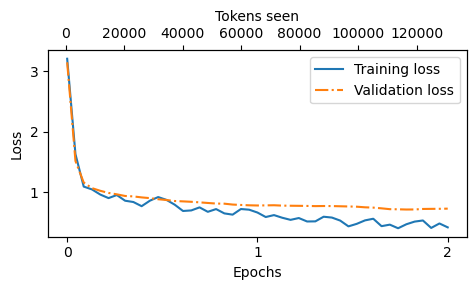

In [37]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Extracting and saving responses

1. Extract the model-generated response for each input in the test dataset, and collect them for manual analysis
2. Evaluate the LLM to quantify the quality of the responses

In [39]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256,
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text) :].replace("### Response:", "").strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud typically associated with thunderstorms is the active layer.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request. 

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pri

236-249

Proper evaluation of instruction fine-tuning is challenging. Several approaches:
- Short-answer + multiple-choice benchmarks (MMLU: Measuring Massive Multitask Language Understanding)
- Human preference comparison to other LLMs (LMSYS chatbot arena)
- Automated conversational benchmarks: AlpacaEval

Here: AlpacaEval-inspired approach -> use another LLM to evaluate our model's response

Generating test set responses: we just add the model response to the existing test set dict so that we can easily compare

In [42]:
len(test_data)

110

In [46]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256,
    )
    
    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    response_text = (
        generated_text[len(input_text) :].replace("### Response:", "").strip()
    )
    test_data[i]["model_response"] = response_text
    
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [00:44<00:00,  2.49it/s]


In [47]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_output': 'The car is as fast as a horse.', 'model_response': 'The car is as fast as a horse.'}


Save the model

In [48]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth" # removes spaces, parentheses
torch.save(model.state_dict(), file_name)
print("Model saved to:", file_name)

Model saved to: gpt2-small124M-sft.pth


## Evaluating the fine-tuned LLM

Use ollama for automatic evaluation

In [49]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


Alternative way: Use REST API to interact with the model

In [51]:
import urllib.request

def query_model(
    prompt,
    model="llama3.2",
    url="http://localhost:11434/api/chat",
):
    # create data payload as a dictionary
    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {"seed": 123, "temprature": 0.0, "num_ctx": 2048},
    }
    
    # convert data payload to JSON and encode it to bytes (binary)
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST") # post method
    request.add_header("Content-Type", "application/json")
    
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line) # parse JSON into dictionary
            response_data += response_json["message"]["content"]
    
    return response_data

In [52]:
model = "llama3.2"
result = query_model("What do Llamas eat?", model=model)
print(result)

Llamas are herbivores, which means they primarily eat plant-based foods. Their diet typically consists of:

1. Grasses: They love to graze on various types of grasses, including tall grasses, short grasses, and grass seeds.
2. Hay: Llamas enjoy a variety of hay types, such as timothy hay, alfalfa hay, and clover hay.
3. Grains: They may be fed grains like oats, corn, or barley in moderation.
4. Fruits and vegetables: Fresh fruits and vegetables can be given to llamas as treats or added to their diet as a supplement.
5. Forages: Llamas will also eat forages like leaves, branches, and shrubs.

It's essential to note that llamas have specific nutritional needs, so it's crucial to provide them with a balanced diet that includes:

* High-quality hay (70-80% of their diet)
* Limited amounts of grains (10-20% of their diet)
* Fresh fruits and vegetables (5-10% of their diet)

A well-balanced diet will help maintain the llama's overall health, energy levels, and digestive system.


Using llama to score the response quailty

In [53]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry["output"])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.

Score:
>> I would rate the model response "The car is as fast as a horse" a 20.

This response does not use a simile (a comparison between two unlike things using "like" or "as") correctly. A simile should compare two unlike things, but in this case, comparing speed to a horse doesn't make sense.

A correct simile would be something like "The car is as fast as lightning." This response uses the word "as" to make a comparison between two unlike things (speed and lightning), which meets the criteria for a simile.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud typically associated with thunderstorms is the active layer.

Score:
>> I would rate the model response "A type of cloud typically associated with thunderstorms is the active layer." as a 20.

The reason for this low

In [56]:
def generate_model_scores(json_data, json_key, model="llama3.2"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model=model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

In [57]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  10%|█         | 11/110 [00:03<00:33,  2.91it/s]

Could not convert score: The correct output should be:

 Prime numbers: 11, 19
 Composite numbers: 14

Score: 80


Scoring entries:  15%|█▌        | 17/110 [00:05<00:30,  3.00it/s]

Could not convert score: 50

The corrected response should be:

Mercury - Liquid
Oxygen - Gas
Wood - Solid


Scoring entries:  16%|█▋        | 18/110 [00:05<00:33,  2.78it/s]

Could not convert score: 80

A note was left by someone.


Scoring entries:  29%|██▉       | 32/110 [00:09<00:25,  3.07it/s]

Could not convert score: The rewritten sentence is: "It's very easy."

Score: 80


Scoring entries:  44%|████▎     | 48/110 [00:12<00:15,  4.03it/s]

Could not convert score: Statement. 
90


Scoring entries:  46%|████▋     | 51/110 [00:14<00:30,  1.95it/s]

Could not convert score: 80

The original text has an error in the verb form of "birds". The correct form should be "sing" instead of "sings". The corrected response is `The birds sing beautiful songs.`


Scoring entries:  61%|██████    | 67/110 [00:18<00:15,  2.70it/s]

Could not convert score: The rewritten sentence as a question is: "Did the dog chase the cat?"

Score: 0


Scoring entries:  65%|██████▍   | 71/110 [00:19<00:11,  3.44it/s]

Could not convert score: Score: 60


Scoring entries:  67%|██████▋   | 74/110 [00:22<00:35,  1.03it/s]

Could not convert score: 60

Technical documents are instructional texts that provide detailed information about a product, process, or service, often including technical specifications and instructions for use or installation. They can be written in various styles, but their primary purpose is to inform or instruct the reader on how to accomplish something.

In this case, the provided text fits the definition of a technical document because it explicitly mentions installing software and provides instructions for doing so. The text's focus on providing step-by-step guidance makes it an example of a technical document.


Scoring entries:  79%|███████▉  | 87/110 [00:27<00:15,  1.48it/s]

Could not convert score: 80

The sentence "Me and my friend went to the store" should be corrected to "My friend and I went to the store." 

As for the additional response "The store was very crowded", it does not seem related to the original task of correcting a sentence, so I will ignore it.


Scoring entries:  98%|█████████▊| 108/110 [00:32<00:00,  2.72it/s]

Could not convert score: The classification of the sentence 'Please open the door.' is imperative.

Score: 90


Scoring entries: 100%|██████████| 110/110 [00:33<00:00,  3.31it/s]

Number of scores: 99 of 110
Average score: 43.26



How to further improve the model
- Tune hyperparamters: learning rate, batch size, no. epochs, etc.
- Increase training dataset size
- Diversify examples
- Experiment w/ different prompts and instruction formats
- Use a larger pretrained model

Nex steps
- Preference fine tuning: customize a model to better align w/ specific user preference